# Aula 12 - OCR de recibos

Exercício Baseline

**Aluno:** Gustavo G. Plensack - RA:155662

Para esta semana, estou aprendendo a usar alguns dos métodos descritos na última aula. Vou consolidar aqui:

https://github.com/gustavoplensack/ia376-projeto-final

Meus objetivos são:

- [ ] Obter o resultado abaixo usando script ao invés do notebook;
- [ ] Adicionar teste das métricas de avaliação;
- [ ] Busca por hiperparâmetros;
- [ ] Avaliação dos checkpoints obtidos;
- [ ] Preparação de relatório;

## Trabalho última aula

Partindo dos dados OCRizados do [dataset SROIE da competição ICDAR 2019.](https://rrc.cvc.uab.es/?ch=13&com=introduction), usar um T5 para identificar o nome da empresa e o endereço na nota fiscal.

**Métricas:** usar o código abaixo para calcular o exact match da resposta toda e F1 de palavras.

In [ ]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip .
!unzip -q dataset_sroie_icdar_2019.zip

Skipping existing item: file://./dataset_sroie_icdar_2019.zip
replace test/X51008099073.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [ ]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
compute_f1(a_gold='He likes pizza', a_pred='she likes pizza')

0.6666666666666666

In [ ]:
compute_exact(a_gold='He likes pizza', a_pred='she likes pizza')

0

# Instalação de pacotes e importação das libs

In [ ]:
!pip install -q pytorch-lightning transformers sentencepiece
# datasets is here to bring sentencepiece and other dependencies
# to make transformers work properly.

In [ ]:
# Python default libs
import os
from collections import Counter,OrderedDict
from random import choice
from itertools import chain
import glob

# Typing stuff
from typing import List

# IPython libs
from IPython.display import Image

# Data management
import json
from h5py import File, Dataset
import pandas as pd

# Torch imports and related libs
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# PL stuff
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

# Numpy import, useful for image handling
import numpy as np

# Pandas for data analysis
import pandas as pd

# Tools to visualize images
import matplotlib.pyplot as plt
import cv2
from matplotlib.pyplot import imshow

# Transformer import
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Colab tools
from google.colab import drive

In [ ]:
'''
Device checking
'''
seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

if torch.cuda.is_available():
    GPU = torch.cuda.get_device_name()
    print(f'Availale GPU is: {GPU}')

Using device: cuda
Availale GPU is: Tesla K80


In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Parâmetros do experimento

In [ ]:
# Global parameters for the experiment
BATCH_SIZE = 8
LEARNING_RATE=3e-4

# NLP defs
SEQ_LEN = 128
T5_TYPE = 't5-small'
T5_TOK = T5Tokenizer.from_pretrained(T5_TYPE)


# Auxiliary vars for debugging runtime :)
TRAIN_MODEL = True

# Dataset

In [ ]:
CSV_FILE = pd.read_csv(
    '/content/drive/My Drive/datasets/ocrized-SROIE/ocr_baseline.csv',
    index_col=0)

In [ ]:
# Checking consistency: all the rows in file_id must be unique
assert len(CSV_FILE.index.unique()) == len(CSV_FILE)

In [ ]:
CSV_FILE.head()

,ocr_gvision_output
file_id,
X00016469612,"{\n ""textAnnotations"": [\n {\n ""local..."
X00016469619,"{\n ""textAnnotations"": [\n {\n ""local..."
X00016469620,"{\n ""textAnnotations"": [\n {\n ""local..."
X00016469622,"{\n ""textAnnotations"": [\n {\n ""local..."
X00016469623,"{\n ""textAnnotations"": [\n {\n ""local..."


In [ ]:
# The text from the sample can be extracted for the 
file_id = CSV_FILE.iloc[0].index
sample = CSV_FILE.iloc[0]['ocr_gvision_output']


json_sample = json.loads(sample)['textAnnotations']

json_sample[0]['description'],file_id

('tan woon yann\nBOOK TAK (TAMAN DAYA) SDN BHD\n789417-W\nNO.5: 55,57 & 59, JALAN SAGU 18.\nTAMAN DAYA\n81100 JOHOR BAHRU,\nJOHOR\nDocument No: TD01167104\nDale\nCashier:\nMember:\n25/12/2018 8:13:39 PM\nMANIS\nCASH BILL\nDisc\nCODE/DESC\nQTY\nPRICE\nRIA\nAMOUNT\nRM\n9556939040116\nKF MODELLING CLAY KIDDY FISH\n9.000 0.00\n1 PC\n9.00\n9.00\nTotal:\nRour ding Adjustment:\nRound d Total (RM);\n0.00\n9.00\nCash\nCHANGE\n10.00\n1,00\n9.00\nGOODS SOLD ARE NOT RETURNABLE OR\nEXCHANGEABLE\nTHANK YOU\nPLEASE CONE AGAIN!\n',
 Index(['ocr_gvision_output'], dtype='object'))

In [ ]:
def load_text_jpeg_pairs(path_to_files:str):
    '''
    Returns a list with tuples of [(path_to_image,path_to_text)].

    Args:
        - path_to_files (str): The path to the files.
    '''

    img_files = glob.glob(f'{path_to_files}/*.jpg')
    txt_files = glob.glob(f'{path_to_files}/*.txt')

    # Asserting that data is sorted,
    # so the pairs are matching
    img_files.sort()
    txt_files.sort()

    return [sample for sample in zip(img_files,txt_files)]

train_samples = load_text_jpeg_pairs('train')
val_samples = load_text_jpeg_pairs('test')
test_samples = load_text_jpeg_pairs('test')

print('JPG/TXT pair example:')
img_path, txt_path = train_samples[0]

img_path, txt_path

JPG/TXT pair example:


('train/X00016469612.jpg', 'train/X00016469612.txt')

In [ ]:
'''
Testing that the pairs are correct
'''
train_sample = json.load(open(txt_path))

train_sample

{'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.',
 'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD',
 'date': '25/12/2018',
 'total': '9.00'}

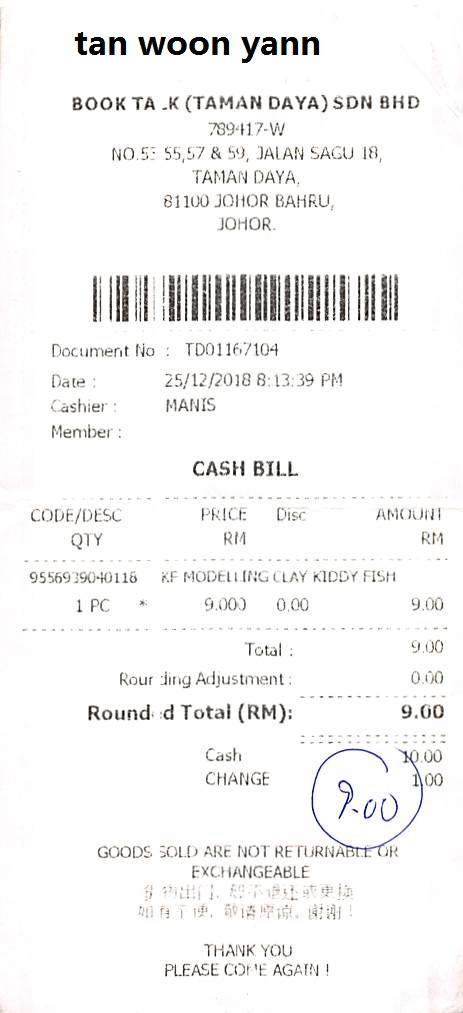

In [ ]:
# Shows the image sample to check if the OCRized text is
# coherent to the Image file.
Image(filename=img_path)

## Dataset do Pytorch
Implementa o dataset do Pytorch combinando os dados ocrizados com as anotações dos documentos do próprio dataset.

In [ ]:
class OCRDataset(Dataset):
    '''
    Pytorch's dataset abstraction to build images from text GCV OCR of the
    recipts alongside with the document annotations provided by the SROIE
    official dataset.

    Args:
        - dataset: list of tuples, with paths to images and samples in targets.
    '''

    def __init__(self, dataset:List):
        
        self._dataset = dataset
        self._tokenizer = T5_TOK
    
    def index_csv_from_current_sample(self, file_name:str):
        '''
        Idexes the CSV file from the file name
        '''
        # cleans the 'slice/FILE.txt' to be only SLICE.
        cleaned_file_name = file_name.split('/')[-1]
        cleaned_file_name = cleaned_file_name.split('.')[0]

        ocrized_sample = \
         CSV_FILE.loc[cleaned_file_name]['ocr_gvision_output']

        json_sample = json.loads(ocrized_sample).get('textAnnotations')[0]

        ocrized_text = json_sample.get('description')

        ocrized_text = ocrized_text.replace('\n',' ')

        return ocrized_text

    def __len__(self):
        return len(self._dataset)

    def read_from_json(self, json_path:str):
        '''
        Reads the data from the JSON.
        '''
        data = json.load(open(json_path))
        
        company = data.get('company','')
        address = data.get('address','')
        
        return f'company: {company}, address: {address}'

    def __getitem__(self, idx):

        _,txt_file = self._dataset[idx]

        target = self.read_from_json(txt_file)
        source = self.index_csv_from_current_sample(txt_file)

        source_tokenized = T5_TOK.encode_plus(source,
                                pad_to_max_length=True,
                                max_length=SEQ_LEN,
                                return_tensors='pt')

        target_tokenized = T5_TOK.encode_plus(target,
                                pad_to_max_length=True,
                                max_length=SEQ_LEN,
                                return_tensors='pt')

        source_token_ids = source_tokenized['input_ids'].squeeze()
        source_mask = source_tokenized['attention_mask'].squeeze()
        original_source = source
        
        target_token_ids = target_tokenized['input_ids'].squeeze()
        target_mask = target_tokenized['attention_mask'].squeeze()
        original_target = target

        return (source_token_ids, source_mask, original_source, 
                target_token_ids, target_mask, original_target)

# Instantiate the DS to test the samples
train_ds = OCRDataset(train_samples)
val_ds = OCRDataset(test_samples)
test_ds = OCRDataset(test_samples)

x_tokens, x_mask, x_original, y_tokens, y_mask, y_original = train_ds[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
T5_TOK.decode(x_tokens), x_original

('tan woon yann BOOK TAK (TAMAN DAYA) SDN BHD 789417-W NO.5: 55,57 & 59, JALAN SAGU 18. TAMAN DAYA 81100 JOHOR BAHRU, JOHOR Document No: TD01167104 Dale Cashier: Member: 25/12/2018 8:13:39 PM MANIS CASH BILL Disc CODE/DESC QTY PRICE RIA AMOUNT RM 9556939040116 KF MODELLING</s>',
 'tan woon yann BOOK TAK (TAMAN DAYA) SDN BHD 789417-W NO.5: 55,57 & 59, JALAN SAGU 18. TAMAN DAYA 81100 JOHOR BAHRU, JOHOR Document No: TD01167104 Dale Cashier: Member: 25/12/2018 8:13:39 PM MANIS CASH BILL Disc CODE/DESC QTY PRICE RIA AMOUNT RM 9556939040116 KF MODELLING CLAY KIDDY FISH 9.000 0.00 1 PC 9.00 9.00 Total: Rour ding Adjustment: Round d Total (RM); 0.00 9.00 Cash CHANGE 10.00 1,00 9.00 GOODS SOLD ARE NOT RETURNABLE OR EXCHANGEABLE THANK YOU PLEASE CONE AGAIN! ')

In [ ]:
T5_TOK.decode(y_tokens), y_original

('company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>',
 'company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.')

In [ ]:
train_dataloader = DataLoader(train_ds,batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_ds,batch_size=1)
test_dataloader = DataLoader(test_ds,batch_size=1)

In [ ]:
x_tokens.shape, x_mask.shape, x_original, y_tokens.shape, y_mask.shape, y_original

(torch.Size([128]),
 torch.Size([128]),
 'tan woon yann BOOK TAK (TAMAN DAYA) SDN BHD 789417-W NO.5: 55,57 & 59, JALAN SAGU 18. TAMAN DAYA 81100 JOHOR BAHRU, JOHOR Document No: TD01167104 Dale Cashier: Member: 25/12/2018 8:13:39 PM MANIS CASH BILL Disc CODE/DESC QTY PRICE RIA AMOUNT RM 9556939040116 KF MODELLING CLAY KIDDY FISH 9.000 0.00 1 PC 9.00 9.00 Total: Rour ding Adjustment: Round d Total (RM); 0.00 9.00 Cash CHANGE 10.00 1,00 9.00 GOODS SOLD ARE NOT RETURNABLE OR EXCHANGEABLE THANK YOU PLEASE CONE AGAIN! ',
 torch.Size([128]),
 torch.Size([128]),
 'company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.')

In [ ]:
next(iter(train_dataloader))

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[tensor([[    3,    17,   152,  ..., 12735,  2365,     1],
         [    3,    17,   152,  ..., 15582,   553,     1],
         [    3,    17,   152,  ...,     3,    18,     1],
         ...,
         [    3,    17,   152,  ...,     7,     3,     1],
         [    3,    17,   152,  ..., 14146,    10,     1],
         [    3,    17,   152,  ...,   683, 16847,     1]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 ('tan woon yann BOOK TAK (TAMAN DAYA) SDN BHD 789417-W NO.5: 55,57 & 59, JALAN SAGU 18. TAMAN DAYA 81100 JOHOR BAHRU, JOHOR Document No: TD01167104 Dale Cashier: Member: 25/12/2018 8:13:39 PM MANIS CASH BILL Disc CODE/DESC QTY PRICE RIA AMOUNT RM 9556939040116 KF MODELLING CLAY KIDDY FISH 9.000 0.00 1 PC 9.00 9.00 Total: Rour ding Adjustment: Round d Total (RM); 0.00 9.00 Cash CHANGE 10.00 1,00 9.00 

# Modelo

In [ ]:
class T5Module(pl.LightningModule):
    '''
    Neural network built with an efficient-net for image feature extraction and
    a T5 for text generation. This 
    '''

    def __init__(self,train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 test_dataloader=test_dataloader):
        super().__init__()

        self.t5 = \
            T5ForConditionalGeneration.from_pretrained(T5_TYPE,
                                                       return_dict=True,
                                                       output_attentions=True)

        self._train_dataloader = train_dataloader
        self._val_dataloader = val_dataloader
        self._test_dataloader = test_dataloader


    def forward(self, x_tokens, x_mask, x_original,
                y_tokens, y_mask, y_original):

        if self.training:
            loss = self.t5.forward(
                input_ids = x_tokens,
                labels = y_tokens,
                )[0]
            
            return loss
        else:
            predicted_token_ids = self.t5.generate(
                x_tokens, max_length=SEQ_LEN
                )
            
            return predicted_token_ids

    def training_step(self, batch, batch_idx):

        x_tokens, x_mask, x_original, y_tokens, y_mask, y_original = batch
        loss = self(x_tokens, x_mask, x_original,
                y_tokens, y_mask, y_original)

        return {"loss": loss, "log": {"step_loss": loss}}

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        
        tqdm_dict = {"train_loss": loss}

        return {"log": tqdm_dict, "progress_bar": tqdm_dict}
        
    def validation_step(self, batch, batch_idx):
        x_tokens, x_mask, x_original, y_tokens, y_mask, y_original = batch

        preds = self(x_tokens, x_mask, x_original,
                y_tokens, y_mask, y_original)

        decoded_preds = [T5_TOK.decode(
            pred,skip_special_tokens=True) for pred in preds]

        return {"pred": decoded_preds, "target": y_original}      
    
    def validation_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # Select a random sample from the trues and preds
        true, pred = choice(list(zip(trues,preds)))

        print(f"\n tgt: {true}\n prd: {pred}\n")

        
        em = np.average([compute_exact(g, r) for g, r in zip(preds, trues)])
        f1 = np.average([compute_f1(g, r) for g, r in zip(preds, trues)])

        self.log("val_em",em,prog_bar=True)
        self.log("val_f1",f1,prog_bar=True)

        return


    def test_step(self, batch, batch_idx):
        x_tokens, x_mask, x_original, y_tokens, y_mask, y_original = batch

        preds = self(x_tokens, x_mask, x_original,
                y_tokens, y_mask, y_original)

        decoded_preds = [T5_TOK.decode(
            pred,skip_special_tokens=True) for pred in preds]
            
        return {"pred": decoded_preds, "target": y_original}      
    
    def test_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # Select a random sample from the trues and preds
        true, pred = choice(list(zip(trues,preds)))

        print(f"\n tgt: {true}\n prd: {pred}\n")


        em = np.average([compute_exact(g, r) for g, r in zip(preds, trues)])
        f1 = np.average([compute_f1(g, r) for g, r in zip(preds, trues)])


        self.log("test_em",em,prog_bar=True)
        self.log("test_f1",f1,prog_bar=True)

        return

    def train_dataloader(self):
        return self._train_dataloader
    
    def val_dataloader(self):
        return self._val_dataloader

    def test_dataloader(self):
        return self._test_dataloader

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=LEARNING_RATE)

model = T5Module().to(device)

# Fast dev run to assert that the model is able to learn
trainer = pl.Trainer(gpus=1, 
                    checkpoint_callback=False,  # Disable checkpoint saving.
                    fast_dev_run=True,
                    )
trainer.fit(model)
trainer.test(model)

try:
    del model
    del trainer
except:
    print('unable to delete trainer and model, they may not be instantiated')

Some weights of the model checkpoint at t5-small were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)



 tgt: company: AEON CO. (M) BHD, address: 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
 prd: KUALA LUMPUR GST ID : 002017394688 SHOPPING HOURS SUN-THU: 1000 HRS - 2230 HRS FRI-SAT: 1000 HRS - 2300 HRS VALUED CUSTOMER: 1170008317 11.25SR 10.50SR 45.90 GST ID : 002017394688 SHOPPING HOURS SUN-THU: 1000 HRS - 2230 HRS FRI-SAT: 1000 HRS




/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)



 tgt: company: AEON CO. (M) BHD, address: 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
 prd: KUALA LUMPUR GST ID : 002017394688 SHOPPING HOURS SUN-THU: 1000 HRS - 2230 HRS FRI-SAT: 1000 HRS - 2300 HRS VALUED CUSTOMER: 1170008317 11.25SR 10.50SR 45.90 GST ID : 002017394688 SHOPPING HOURS SUN-THU: 1000 HRS - 2230 HRS FRI-SAT: 1000 HRS

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_em': 0.0, 'test_f1': 0.06557377049180328}
--------------------------------------------------------------------------------



## Overfit em uma amostra

In [ ]:
'''
Overfit is not being done, because the generation of the dataset relies on
randomness, so it this will never overfit. Altough using a fixed combination
of shapes the model has overfitted to a single sample and for a single batch.
'''
OVERFIT = True


if OVERFIT:
    trainer = pl.Trainer(gpus=1,
                        max_epochs=300,
                        check_val_every_n_epoch=20,
                        checkpoint_callback=False,  # Disable checkpoint saving
                        overfit_batches=1)

    debug_dataloader_train = DataLoader(train_ds, 
                                        batch_size=1,
                                        shuffle=True)

    debug_dataloader_val = DataLoader(train_ds, 
                                        batch_size=1,
                                        shuffle=True)

    model = T5Module(train_dataloader=debug_dataloader_train,
                    val_dataloader=debug_dataloader_val)

    trainer.fit(model)
    trainer.test(model)

try:
    del model

except:
    print('unable to delete model, probably not instantiated ...')

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Some weights of the model checkpoint at t5-small were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificati

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: BOOK TAK (TAMAN DAYA) SDN BHD 789417-W NO.5: 55,57 & 59, JALAN SAGU 18. TAMAN DAYA 81100 JOHOR BAHRU, JOHOR Document No: TD01167104 Dale Cashier: Member: 25/12/2018 8:13:39 PM MANIS CASH BILL Disc CODE/DESC QTY PRICE RIA AMOUNT RM 9556939040



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)



 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: 




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: 




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: 




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: 




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: 




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.





 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_em': 0.0, 'test_f1': 0.9302325581395349}
--------------------------------------------------------------------------------



## Overfit em um batch

In [ ]:
'''
Overfit is not being done, because the generation of the dataset relies on
randomness, so it this will never overfit. Altough using a fixed combination
of shapes the model has overfitted to a single sample and for a single batch.
'''

OVERFIT_BATCH = True

if OVERFIT_BATCH:
    trainer = pl.Trainer(gpus=1,
                        max_epochs=300,
                        check_val_every_n_epoch=20,
                        checkpoint_callback=False,  # Disable checkpoint saving
                        overfit_batches=1)

    debug_dataloader_train = DataLoader(train_ds, 
                                        batch_size=8,
                                        shuffle=False)

    debug_dataloader_val = DataLoader(train_ds, 
                                        batch_size=8,
                                        shuffle=False)

    model = T5Module(train_dataloader=debug_dataloader_train,
                    val_dataloader=debug_dataloader_val)

    trainer.fit(model)
    trainer.test(model)

try:
    del model
    del trainer

except:
    print('unable to delete model, probably not instantiated ...')

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Some weights of the model checkpoint at t5-small were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificati

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 tgt: company: MR D.I.Y. (M) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI)
 prd: MR D.I.Y. (M) SDN BHD (CO.REG: 860671-D) 10T 1851-A &1851-B, JALAN KPB 6. KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI -INVOICE- KILAT AUTO FCO WASH & SHINE ES1000 TL WA45-72



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)



 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: 




 tgt: company: MR D.I.Y. (JOHOR) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (MR DIY TESCO TERBAU)
 prd: 




 tgt: company: SOON HUAT MACHINERY ENTERPRISE, address: NO.53 JALAN PUTRA 1, TAMAN SRI PUTRA, 81200 JOHOR BAHRU JOHOR
 prd: 




 tgt: company: ABC HO TRADING, address: NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR
 prd: 




 tgt: company: MR D.I.Y. (M) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI)
 prd: company: MR D.I.Y. (M) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI)




 tgt: company: MR D.I.Y. (JOHOR) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (MR DIY TESCO TERBAU)
 prd: company: MR D.I.Y. (JOHOR) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (MR DIY TESCO TERBAU)




 tgt: company: YONGFATT ENTERPRISE, address: NO 122.124. JALAN DEDAP 13 81100 JOHOR BAHRU
 prd: company: YONGFATT ENTERPRISE, address: NO 122.124. JALAN DEDAP 13 81100 JOHOR BAHRU




 tgt: company: ABC HO TRADING, address: NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR
 prd: company: ABC HO TRADING, address: NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR




 tgt: company: INDAH GIFT & HOME DECO, address: 27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: INDAH GIFT & HOME DECO, address: 27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: INDAH GIFT & HOME DECO, address: 27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: INDAH GIFT & HOME DECO, address: 27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: SOON HUAT MACHINERY ENTERPRISE, address: NO.53 JALAN PUTRA 1, TAMAN SRI PUTRA, 81200 JOHOR BAHRU JOHOR
 prd: company: SOON HUAT MACHINERY ENTERPRISE, address: NO.53 JALAN PUTRA 1, TAMAN SRI PUTRA, 81200 JOHOR BAHRU JOHOR




 tgt: company: INDAH GIFT & HOME DECO, address: 27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: INDAH GIFT & HOME DECO, address: 27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.




 tgt: company: ABC HO TRADING, address: NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR
 prd: company: ABC HO TRADING, address: NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR




 tgt: company: ABC HO TRADING, address: NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR
 prd: company: ABC HO TRADING, address: NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR




 tgt: company: MR D.I.Y. (M) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI)
 prd: company: MR D.I.Y. (M) SDN BHD, address: LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI)





 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_em': 0.875, 'test_f1': 0.9912790697674418}
--------------------------------------------------------------------------------



# Fine Tunning

Nesta seção é realizado o fine-tunning para garantir que 

In [ ]:
train_dataloader = DataLoader(train_ds,batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_ds,batch_size=1)
test_dataloader = DataLoader(test_ds,batch_size=1)

In [ ]:
# A implementação do trainer foi usada a do Rodrigo proposta para o semestre
# passado.

max_epochs = 50

model = T5Module()

checkpoint_path = '/content/drive/My Drive/t5-on-ocr/epoch=49.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir,
                                      save_top_k=-1, # Keeps all checkpoints.
                                      monitor = 'val_f1')  

resume_from_checkpoint = None
if os.path.exists(checkpoint_path):
    print(f'Restoring checkpoint: {checkpoint_path}')
    resume_from_checkpoint = checkpoint_path
    print('Using checkpoint:',resume_from_checkpoint)

trainer = pl.Trainer(gpus=1,
                     max_epochs=max_epochs,
                     check_val_every_n_epoch=1, #High number, so it never evals
                     profiler=True,
                     checkpoint_callback=checkpoint_callback,
                     progress_bar_refresh_rate=50,
                     resume_from_checkpoint=resume_from_checkpoint)

Some weights of the model checkpoint at t5-small were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files in /content/drive/My Drive/t5-on-ocr: ['epoch=0.ckpt', 'epoch=1.ckpt', 'epoch=2.ckpt', 'epoch=3.ckpt', 'epoch=4.ckpt', 'epoch=5.ckpt', 'epoch=6.ckpt', 'epoch=7.ckpt', 'epoch=8.ckpt', 'epoch=9.ckpt', 'epoch=10.ckpt', 'epoch=11.ckpt', 'epoch=12.ckpt', 'epoch=13.ckpt', 'epoch=14.ckpt', 'epoch=15.ckpt', 'epoch=16.ckpt', 'epoch=17.ckpt', 'epoch=18.ckpt', 'epoch=19.ckpt', 'epoch=20.ckpt', 'epoch=21.ckpt', 'epoch=22.ckpt', 'epoch=23.ckpt', 'epoch=24.ckpt', 'epoch=25.ckpt', 'epoch=26.ckpt', 'epoch=27.ckpt', 'epoch=28.ckpt', 'epoch=29.ckpt', 'epoch=30.ckpt', 'epoch=31.ckpt', 'epoch=32.ckpt', 'epoch=33.ckpt', 'epoch=34.ckpt', 'epoch=35.ckpt', 'epoch=36.ckpt', 'epoch=37.ckpt', 'epoch=38.ckpt', 'epoch=39.ckpt', 'epoch=40.ckpt', 'epoch=41.ckpt', 'epoch=42.ckpt', 'epoch=43.ckpt', 'epoch=44.ckpt', 'epoch=45.ckpt', 'epoch=46.ckpt', 'epoch=47.ckpt', 'epoch=48.ckpt', 'epoch=49.ckpt']
Saving checkpoints to /content/drive/My Drive/t5-on-ocr
Restoring checkpoint: /content/drive/My Drive/t5-on-ocr/epo

In [ ]:
TRAIN = True
if TRAIN:
    trainer.fit(model)
else:
    print('T5 is not being trained')


  | Name | Type                       | Params
----------------------------------------------------
0 | t5   | T5ForConditionalGeneration | 60.5 M


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 tgt: company: AEON CO. (M) BHD, address: 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
 prd: company: AEON CO. (M) BHD, address: 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR





Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_fit_start        	|  3.1066e-05     	|  3.1066e-05     
on_validation_start 	|  3.6554e-05     	|  3.6554e-05     
on_validation_epoch_start	|  2.246e-05      	|  2.246e-05      
on_validation_batch_start	|  2.2812e-05     	|  4.5625e-05     
validation_step_end 	|  3.9882e-05     	|  7.9763e-05     
on_validation_batch_end	|  4.2536e-05     	|  8.5071e-05     
on_validation_epoch_end	|  1.8577e-05     	|  1.8577e-05     
on_validation_end   	|  0.0023848      	|  0.0023848      
on_train_start      	|  0.060892       	|  0.060892       
on_train_end        	|  0.0024393      	|  0.0024393      



In [ ]:
trainer.test(model)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 tgt: company: LEONG HENG SHELL SERVICE STATION, address: LOT 26151 BANDAR SG LONG, 11 1/4 MILES CHERAS, 43000 KAJANG, SELANGOR
 prd: company: LEONG HENG SHELL SERVICE STATION, address: LOT 26151 BANDAR SG LONG, 11 1/4 MILES CHERAS, 43000 KAJANG, SELANGOR

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_em': 0.355, 'test_f1': 0.8725353900110713}
--------------------------------------------------------------------------------



[{'test_em': 0.355, 'test_f1': 0.8725353900110713}]

#Conclusão

O modelo obteve bons resultados recebendo como entrada os valores do OCR.

O exact match poderia ter sido melhor, pois em alguns casos faltou apenas ajustar espaçamentos que e divergências que o modelo não foi capaz de gerar. Como o é o caso de:


```
 tgt: company: BOOK TA .K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
 prd: company: BOOK TA.K (TAMAN DAYA) SDN BHD, address: NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
```
